In [1]:
import pandas as pd
import numpy as np

In [2]:
import re
import nltk

np.random.seed(20)

def preprocess_input(comment):
    comment = comment.strip()  # remove trailing spaces
    comment = comment.lower()  # make every word in the comment to be in lowercase
    comment = re.sub('[\s0-9]',' ', comment)  # removing unnecessary escape sequences from the comment
    comment = re.sub('<[^>]*>', '', comment)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', comment)
    comment = re.sub('[\W]+', ' ', comment.lower()) +\
        ' '.join(emoticons).replace('-', '')
    words = nltk.word_tokenize(comment)  # split the comment into words using nltk
    words = [word for word in words if len(word) > 2 and word not in ["http", "bodyshaming", "com", "https", "io", "twitter", "www"]]  # remove the common words    
    comment = ' '.join(words)
    return comment


In [45]:
train_file = "./DM-data/train.csv"  # train file
test_file = "./DM-data/2017-18_BS_Tweets.csv"   # test file

train_data = pd.read_csv(train_file)  # load train data
test_data = pd.read_csv(test_file, encoding='latin')  # load test data

# train_data = train_data.loc[train_data['toxic'] != 0]

In [46]:
test_rows = test_data.shape[0]
#  train_data = train_data[0:]
train_data = train_data.sample(n=test_rows) ##
train_rows = train_data.shape[0]
test_data = test_data.sample(n=train_rows) ##
test_data["comment_text"] = test_data["comment_text"].apply(preprocess_input)
train_data["comment_text"] = train_data["comment_text"].apply(preprocess_input)

test_data1 = test_data
train_data1 = train_data

In [48]:
test_data1[0:3]

,id,comment_text
14924,_931474457042083840,are people him
11558,_906993360241434624,and they think valid criticism cause for and c...
5804,_868164906230611973,couch chat body shaming kpa


In [5]:
predictions = test_data[["id", "comment_text"]]
predictions["comment_text"] = predictions["comment_text"].apply(preprocess_input)
predictions.loc[:, 'toxic'] = 0.5
predictions.loc[:, 'severe_toxic'] = 0.5
predictions.loc[:, 'obscene'] = 0.5
predictions.loc[:, 'threat'] = 0.5
predictions.loc[:, 'insult'] = 0.5
predictions.loc[:, 'identity_hate'] = 0.5

predictions_svc = predictions

# test_data = shuffle(test_data)

print("Training samples = ", train_data.shape[0])
print("Test samples = ", test_data.shape[0])

Training samples =  20094
Test samples =  20094


In [6]:
labels = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
train_data.drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
test_id = test_data.pop('id')
print(train_data.head())

print("Null values in training data", train_data.isnull().sum(), sep="\n")
print("Null values in testing data", test_data.isnull().sum(), sep="\n")

                                             comment_text
77142   can all see the truth really does hurt someone...
7650    balance find the balance content this article ...
130231  napoleon zervas dear helladios can you stop de...
78522                ooh rah see the noticeboard too talk
5605    kirsten back when she briefly sported longer h...
Null values in training data
comment_text    0
dtype: int64
Null values in testing data
comment_text    0
dtype: int64


In [7]:
data = pd.concat([train_data, test_data])
del train_data
del test_data
print(data.shape)

(40188, 1)


In [8]:
data.comment_text = data.comment_text.apply(lambda row: preprocess_input(row))
print(data.head())

                                             comment_text
77142   can all see the truth really does hurt someone...
7650    balance find the balance content this article ...
130231  napoleon zervas dear helladios can you stop de...
78522                ooh rah see the noticeboard too talk
5605    kirsten back when she briefly sported longer h...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# # Feature Extraction
vect = TfidfVectorizer(min_df=0.1, max_df=0.7,
                       analyzer='char',
                       ngram_range=(1, 3),
                       strip_accents='unicode',
                       sublinear_tf=True,
                       max_features=30
                       )

test = data[train_rows:]
train = data[:train_rows]

vect = vect.fit(train.comment_text)
train = vect.transform(train.comment_text)
test = vect.transform(test.comment_text)

print('Training feature set = ', train.shape)
print('Testing feature set = ', test.shape)

Training feature set =  (20094, 30)
Testing feature set =  (20094, 30)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# # Applying logistic regression model to predict probability of each label
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# predictions = pd.read_csv('./DM-data/sample_submission.csv')
# labels = labels.sample(n = test_rows)

for c in cols:
    clf = LogisticRegression(C=4, solver='sag')
    clf.fit(train, labels[c])
    predictions[c] = clf.predict_proba(test)[:,1]
    score = np.mean(cross_val_score(clf, train, labels[c], scoring='roc_auc', cv=10))
    print("ROC_AUC score for", c, "=", score)

# predictions["comment_text"] = test["comment_text"]
    
predictions.head()
predictions.to_csv('my_submission.csv', index=False)

ROC_AUC score for toxic = 0.7851812999736223
ROC_AUC score for severe_toxic = 0.9059282272075702
ROC_AUC score for obscene = 0.8163212650145271


c:\users\divya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\divya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\divya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\divya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\divya\appdata\l

ROC_AUC score for threat = 0.874405236788862
ROC_AUC score for insult = 0.8184411585715644
ROC_AUC score for identity_hate = 0.7699404143832496


In [ ]:
ROC_AUC score for toxic = 0.7851793227764963
ROC_AUC score for severe_toxic = 0.9059201592965754
ROC_AUC score for obscene = 0.816323213050764
ROC_AUC score for threat = 0.8744052409409837
ROC_AUC score for insult = 0.8184373850997411
ROC_AUC score for identity_hate = 0.7699492748302024

In [36]:
predictions.loc[predictions["toxic"] >=0.6][5:15]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
17949,_951244975223771136,stop him you fool pattymo status,0.629767,0.069781,0.415245,0.031094,0.379609,0.5
1090,_825843345842905090,trump youtu gxnzom,0.658057,0.188679,0.438100,0.043419,0.449422,0.5
9051,_888375744568545282,what you expect from janna nick dah lah haritu...,0.646021,0.055076,0.441156,0.026392,0.476390,0.5
13327,_921836326139281409,sad that you think funny,0.753379,0.208707,0.711170,0.023715,0.626249,0.5
10593,_900246513326096384,slim fat with ugly pic wjg khtjk,0.678055,0.082027,0.674090,0.002510,0.487462,0.5
18050,_952640814479544321,hahahah you should watch hina fire first you g...,0.696684,0.158677,0.550383,0.109309,0.510279,0.5
16343,_938832928330596352,why wont you answer about your,0.616314,0.173353,0.416183,0.022296,0.366637,0.5
13463,_922736538223394816,yeah shame your fat ass body gets cancer eatli...,0.699093,0.122995,0.651078,0.007640,0.557207,0.5
6134,_870401052754849793,you not fat you just easier see mostlysane jok...,0.650323,0.064949,0.469404,0.013659,0.494015,0.5
12132,_911364491438419968,can fat and still out your league via bustle t...,0.636849,0.118032,0.594688,0.007961,0.595050,0.5


In [39]:
replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would')
]
class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
         self.patterns = [(re.compile(regex), repl) for (regex, repl) in
         patterns]
     
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
             s = re.sub(pattern, repl, s)
        return s

In [49]:
tf = TfidfVectorizer( strip_accents='unicode',analyzer='word',ngram_range=(1,1),
            use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

test = test_data1
train = train_data1

In [59]:
from nltk.stem import WordNetLemmatizer
import string
lemmer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import TweetTokenizer
replacer = RegexpReplacer()
tokenizer=TweetTokenizer()

def comment_process(category):
    category_processed=[]
    for i in range(category.shape[0]):
        comment_list=tokenizer.tokenize(replacer.replace(category[i]))
        comment_list_cleaned= [word for word in comment_list if ( word.lower() not in stopwords 
                              and word.lower() not in list(string.punctuation) )]
        comment_list_lemmed=[lemmer.lemmatize(word, 'v') for word in comment_list_cleaned]
        category_processed.extend(list(comment_list_lemmed))
    return category_processed

toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values

toxic1=comment_process(toxic)
severe_toxic1=comment_process(severe_toxic)
obscene1=comment_process(obscene)
threat1=comment_process(threat)
insult1=comment_process(insult)
identity_hate1=comment_process(identity_hate)

In [60]:
def category_to_tfidf(category):
    tvec_weights = tf.fit_transform(category)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tf.get_feature_names(), 'weight': weights})
    return(weights_df.sort_values(by='weight', ascending=False).head(10))

toxic_idf=category_to_tfidf(toxic1)
severe_toxic_idf=category_to_tfidf(severe_toxic1)
threat_idf=category_to_tfidf(threat1)
insult_idf=category_to_tfidf(insult1)
obscene_idf=category_to_tfidf(obscene1)
identity_hate_idf=category_to_tfidf(identity_hate1)

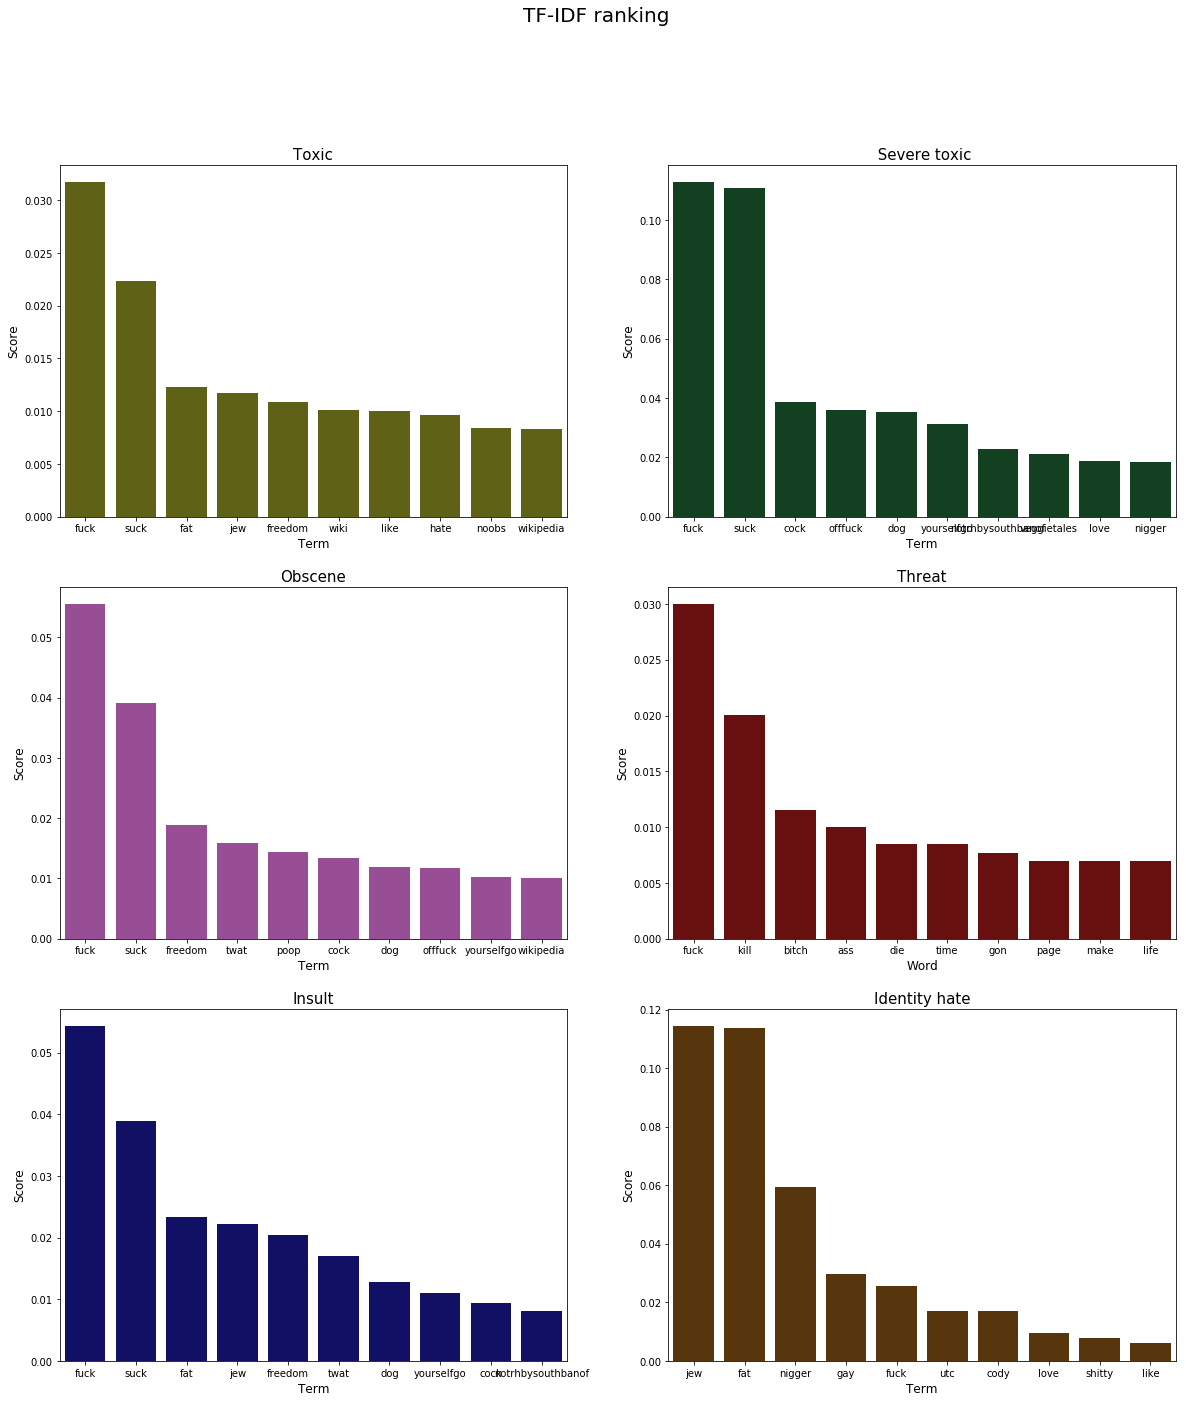

In [61]:
from matplotlib import gridspec

color_list = ["xkcd:brownish green", "xkcd:pine green", "xkcd:ugly purple",
               "xkcd:blood", "xkcd:deep blue", "xkcd:brown"]
plt.figure(figsize=(20,22))
plt.suptitle("TF-IDF ranking ",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplot2grid((3,2),(0,0))
sns.barplot(toxic_idf.term,
            toxic_idf.weight,color=color_list[0])
plt.title("Toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(severe_toxic_idf.term,
            severe_toxic_idf.weight,color=color_list[1])
plt.title(" Severe toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,0))
sns.barplot(obscene_idf.term,
            obscene_idf.weight,color=color_list[2])
plt.title("Obscene",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,1))
sns.barplot(threat_idf.term,
            threat_idf.weight,color=color_list[3])
plt.title("Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(insult_idf.term,
            insult_idf.weight,color=color_list[4])
plt.title("Insult",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(identity_hate_idf.term,
            identity_hate_idf.weight,color=color_list[5])
plt.title("Identity hate",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.show()

In [64]:
# df_train = pd.read_csv('../input/train.csv')
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Adding 'none' columns if there is no '1' in COLUMNS
predictions['none'] = (predictions[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(predictions.shape)
print(predictions.columns.values)

(20094, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


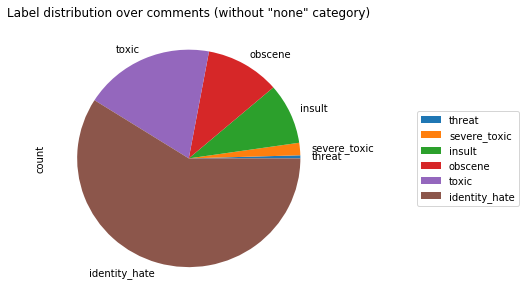

In [65]:
%matplotlib inline

df_distribution = predictions[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [66]:
df_distribution.sort_values('count', ascending=False)

,count
identity_hate,10047.000000
toxic,3222.532897
obscene,1835.067537
insult,1535.837381
severe_toxic,314.117185
threat,77.871167
none,0.000000


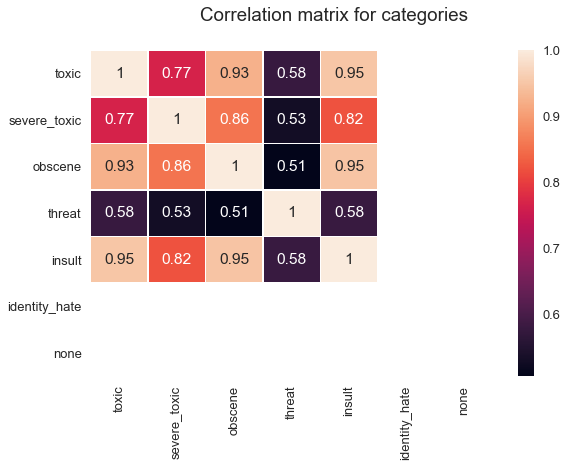

In [67]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context="talk")

f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(predictions[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

In [68]:
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])


from collections import Counter
word_counter = {}
for categ in CATEGORIES:
    d = Counter()
    predictions['comment_text'].apply(lambda t: d.update(clean_text(t).split()))    
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

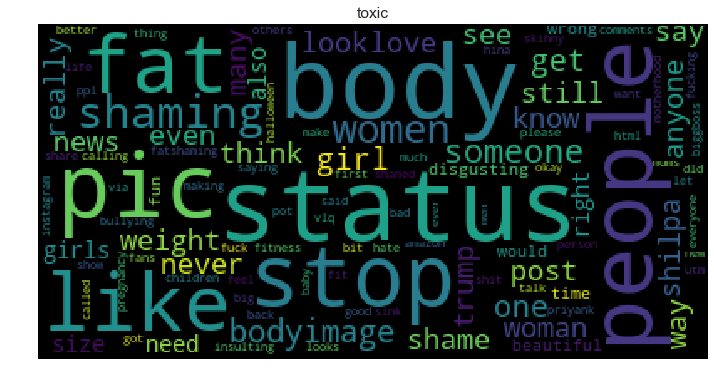

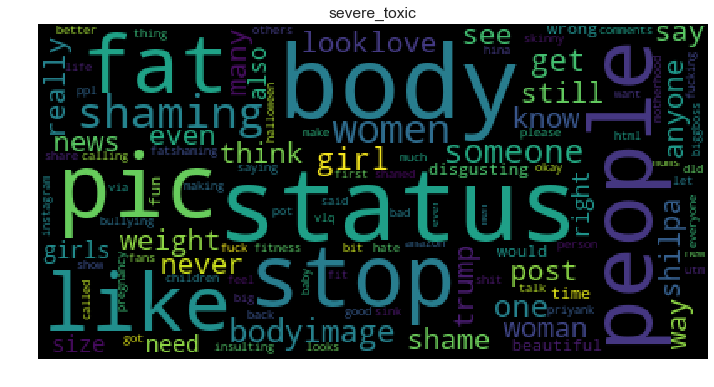

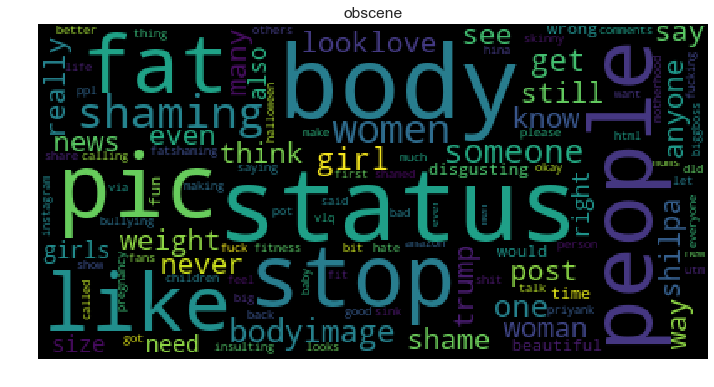

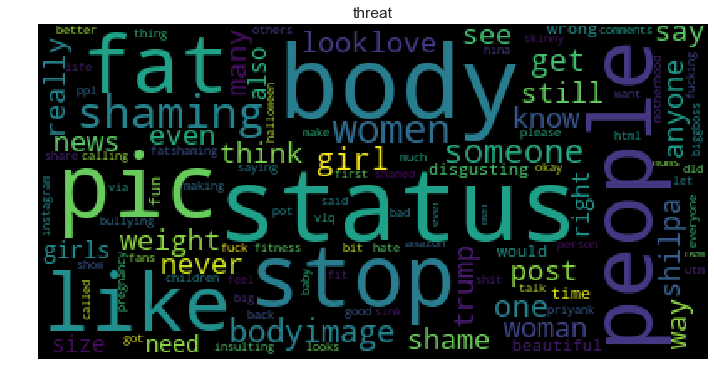

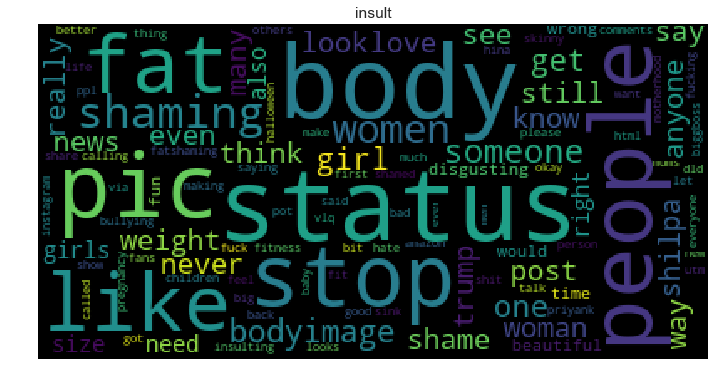

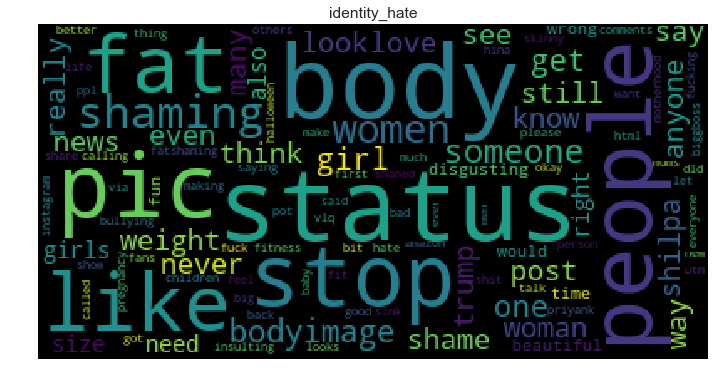

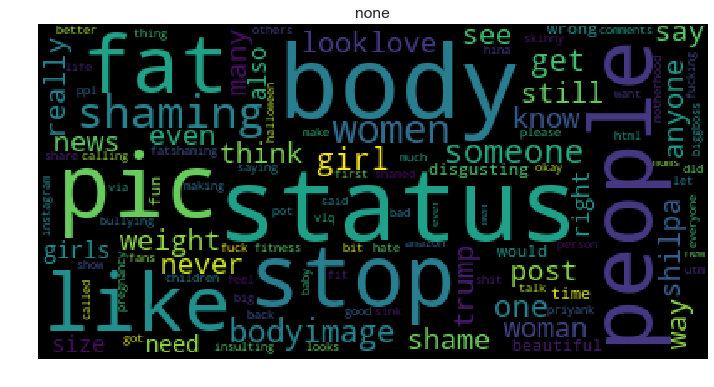

In [72]:
from wordcloud import WordCloud

for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=500,
          max_font_size=60, 
          min_font_size=6, 
          stopwords = stop,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

True

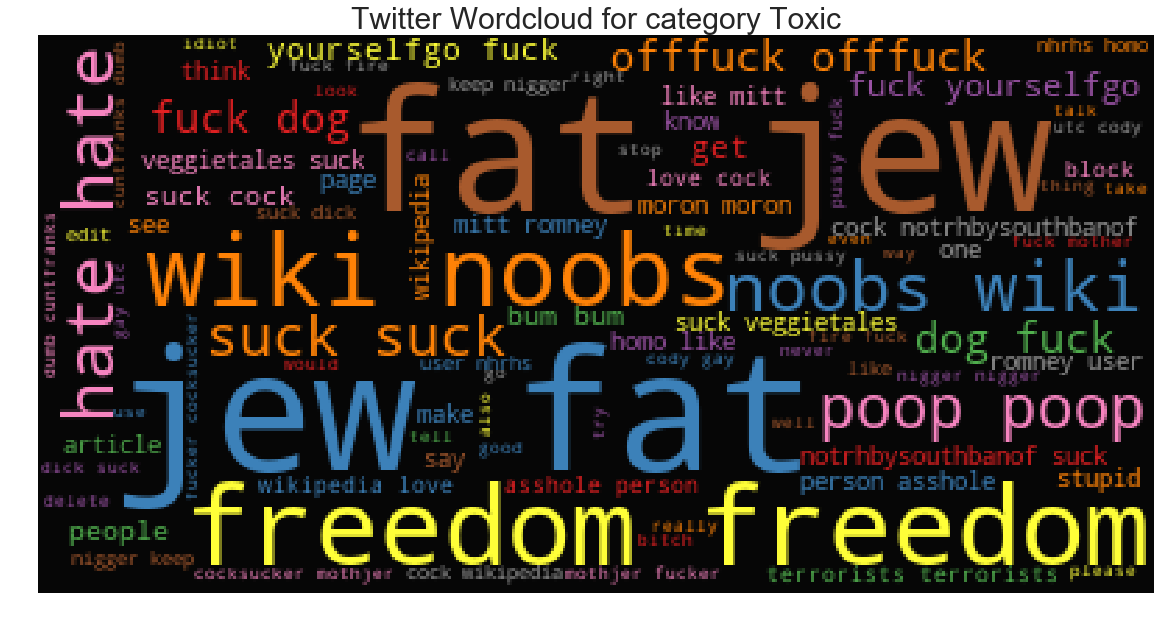

In [74]:
from wordcloud import WordCloud
def wordcloud_plot(category, name) : 
    plt.figure(figsize=(20,15))
    wc = WordCloud(
          background_color='black',
          max_words=500,
          max_font_size=60, 
          min_font_size=6, 
          stopwords = stop,
          random_state=4561
         )
    wc.generate(" ".join(category))
    plt.title("Twitter Wordcloud for category " + name, fontsize=30)
    plt.imshow(wc.recolor( colormap= 'Set1' , random_state=21), alpha=0.98)
    plt.axis('off')
    plt.savefig(name+'_wc.png')
    return(True)

wordcloud_plot(toxic1,'Toxic')